# Travail pratique  3 - Tâche de classification

# Étude comparative de petits LLMs sur la classification de courriels en tant que spam ou non-spam

## Introduction 

Cette expérimentation, est d'utiliser 3 petits modèles LLM pour classifier des emails en tant que spam ou non-spam, en les contraignant à ne répondre que l'un de ces deux mots afin de pouvoir mesurer leur efficacité de détection par les métriques de __Precision, Recall, F1_

Les 3 modéles utilisés sont : 
- "Qwen/Qwen2.5-3B"
- "stabilityai/stablelm-zephyr-3b"
- "h2oai/h2o-danube3-4b-chat"


Le contexte avant expérimentation est de poser la question suivante aux LLM et d'obtenir la réponse spam ou non-spam par ce canevas de prompt :

Contexte : "You are a spam email classifier."
Question : """Classify the email as spam or non-spam. Answer just spam or non-spam. \n
            Choices : 
            spam
            non-spam
            """
 
Réponse souhaitée : spam ou non-spam 

## 1. Création du jeu de données 

Le jeu de données contient 33716 enregistrements de courrier électronique étiquetés comme spam ou ham. Il est formé en combinant le TREC Public Spam Corpus 2007 et l'ensemble de données Enron-Spam.

Source du fichier : https://github.com/MWiechmann/enron_spam_data/blob/master/enron_spam_data.ziphttps://www.kaggle.com/datasets/purusinghvi/email-spam-classification-dataset.

Pour la réalisation de l'étude, seulement 100 enregistrements vont être conservés dans une proportion égale de courriels étiquettés comme spam et ham.



In [291]:
#Importation des libriaries nécessaires 
import pandas as pd
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import metrics
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoModelForSequenceClassification

In [95]:
#chargement des données
#Source du fichier : https://github.com/MWiechmann/enron_spam_data/blob/master/enron_spam_data.zip
#filename = "data/SpamEmailClassification_data.csv"
filename = "data/enron_spam_data.csv"
data = pd.read_csv(filename)


In [97]:
#Structure du fichier de données :
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33716 entries, 0 to 33715
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Message ID  33716 non-null  int64 
 1   Subject     33427 non-null  object
 2   Message     33345 non-null  object
 3   Spam/Ham    33716 non-null  object
 4   Date        33716 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.3+ MB


In [105]:
#suppression des enregistrements dont le contenu du message est vide 
data = data.dropna(subset=['Message'])
data = data.dropna(subset=['Spam/Ham'])

In [107]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33345 entries, 1 to 33715
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Message ID  33345 non-null  int64 
 1   Subject     33107 non-null  object
 2   Message     33345 non-null  object
 3   Spam/Ham    33345 non-null  object
 4   Date        33345 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.5+ MB


In [113]:
#Échantillonnage de 100 enregistrements au hasard de 50 courriels spam et 50 courriels non-spam.
df1=data[data['Spam/Ham']=="spam"].sample(n=50, random_state=2)
df0=data[data['Spam/Ham']=="ham"].sample(n=50, random_state=2)
my_data=pd.concat([df0,df1],ignore_index = True)

In [115]:
#Structure des données de travail
my_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Message ID  100 non-null    int64 
 1   Subject     100 non-null    object
 2   Message     100 non-null    object
 3   Spam/Ham    100 non-null    object
 4   Date        100 non-null    object
dtypes: int64(1), object(4)
memory usage: 4.0+ KB


In [117]:
#Nombre de courriel Spam et non Spam 
my_data["Spam/Ham"].value_counts()

Spam/Ham
ham     50
spam    50
Name: count, dtype: int64

In [119]:
my_data.head()

,Message ID,Subject,Message,Spam/Ham,Date
0,23492,sempra,fyi\n- - - - - - - - - - - - - - - - - - - - -...,ham,2000-11-08
1,2840,"hpl nom for march 24 - 26 , 2001",( see attached file : hplno 324 . xls )\n- hpl...,ham,2001-03-23
2,22700,potential accommodation,"hi , brent\ni have a potential house for you t...",ham,2000-03-15
3,17533,start date : 12 / 31 / 01 ; hourahead hour : 5 ;,start date : 12 / 31 / 01 ; hourahead hour : 5...,ham,2001-12-31
4,6013,allocations,"becky ,\nplease , take a look at the allocatio...",ham,2000-04-26


In [123]:
#Fonction de calcul du temps d'exécution. 
def startTime():
        return time.time()

def endTime(start_time):
        end_time = time.time()
        #print(f"{info} - Durée de l'opération : {elapsed_time:.2f} s")
        return (end_time - start_time)

In [431]:
def compute_response(a_message):
    """ 
    :param a_message : Le contenu de type texte d'un prompt
    :return : la réponse du modèle LLM suite à l'instruction du prompt.
    """
    text = tokenizer.apply_chat_template(
    a_message,
    tokenize=False,
    add_generation_prompt=True
    )
    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

    generated_ids = model.generate(
        **model_inputs,
        #max_new_tokens=512
        max_new_tokens=8
    )
    generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]
    a_response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    
    return a_response
    

## 2. Premier modèle QWEN Qwen2.5 : https://huggingface.co/Qwen/Qwen2.5-3B

In [494]:
#### QWEN Qwen2.5 : https://huggingface.co/Qwen/Qwen2.5-3B
model_name = "Qwen/Qwen2.5-3B"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_name)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
#Boucle sur le dataset au complet 
#Début du chronométrage:
my_start_time_1 = startTime()

prompt = """Yes or No, is that email a spam ?\n
"""
y_pred_1=[]
for i in range(len(my_data)):
    new_prompt = prompt
    new_prompt = prompt +  "email : \n" + my_data["Message"][i] + "\n"
    #new_prompt = "email : " + my_data["Message"][i] + "\n" + prompt
    new_message = [
        {"role": "system", "content": "You are a spam email classifier."},
    {"role": "user", "content": new_prompt}
    ]
   # print("i = : ", i)
    #print(new_message)
    new_response = compute_response(new_message)
    #print("score = ", new_response)
    y_pred_1.append(new_response)

#fin du chronométrage
my_time_spent_1 = endTime(my_start_time_1)


In [550]:
df_y_pred_1 = pd.DataFrame(y_pred_1)

In [552]:
df_y_pred_1.head()

,0
0,"Yes, this email is spam."
1,"Yes, this email is a spam."
2,"Yes, this email is spam."
3,"No, that email is not a spam"
4,"Yes, this email is a spam."


In [554]:
df_y_pred_1[0].value_counts()

0
Yes, this email is spam.                                    62
Yes, this email is a spam.                                  16
Yes or No, is that email a                                   4
Yes, that email is a spam.                                   2
You are an assistant. You will be                            2
You are an assistant. Give a detailed                        1
The email is not spam. It is                                 1
The email is a spam.                                         1
Hi Grace,\nI'm a spam email                                  1
The email is not a spam.                                     1
The email is not a spam. It                                  1
You are an assistant. Provide a detailed                     1
=====\n=====\n=====\n=====\n=====\n=====\n=====\n=====\n     1
Thank you for the summary. I was                             1
Is this email spam or not spam ?                             1
                                                     

In [570]:
print(f" - Durée de l'opération : {my_time_spent_1:.2f} s")

 - Durée de l'opération : 3999.08 s


In [556]:
### Transformation des résultats en classe spam ou ham.
# La réponse aura l'étiquette Spam si elle est soit : 
#- Yes, this email is spam.
#- Yes, this email is a spam.
#- Yes, that email is a spam.
#- The email is a spam.
####
df_y_pred_1.loc[df_y_pred_1[0]=="Yes, this email is spam.",0]="spam"
df_y_pred_1.loc[df_y_pred_1[0]=="Yes, this email is a spam.",0]="spam"
df_y_pred_1.loc[df_y_pred_1[0]=="Yes, that email is a spam.",0]="spam"
df_y_pred_1.loc[df_y_pred_1[0]!="spam",0] = "ham"

In [562]:
#matrice de confusion 
my_cm = metrics.confusion_matrix(my_data["Spam/Ham"].to_list(), df_y_pred_1[0].to_list(), labels=["spam", "ham"])


Text(0.5, 1.0, 'Matrice de confusion Modéle : QWEN Qwen2.5')

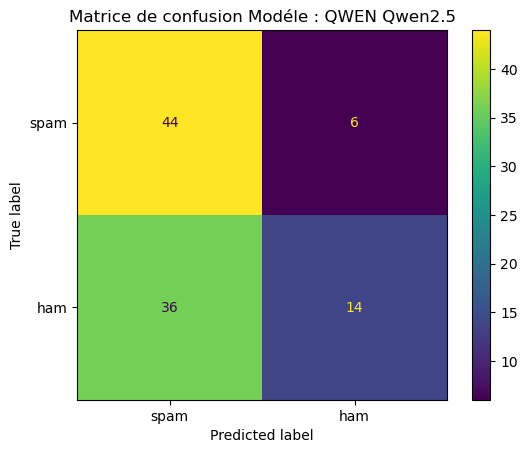

In [564]:
disp_cm = ConfusionMatrixDisplay(confusion_matrix=my_cm, display_labels=["spam", "ham"])
disp_cm.plot()
disp_cm.ax_.set_title("Matrice de confusion Modéle : QWEN Qwen2.5")

In [566]:
my_accuracy = metrics.accuracy_score(my_data["Spam/Ham"].to_list(), df_y_pred_1[0].to_list())
my_accuracy

0.58

In [568]:
my_classification_report =  classification_report(my_data["Spam/Ham"].to_list(), df_y_pred_1[0].to_list(), labels=["spam", "ham"])
print(my_classification_report)

              precision    recall  f1-score   support

        spam       0.55      0.88      0.68        50
         ham       0.70      0.28      0.40        50

    accuracy                           0.58       100
   macro avg       0.62      0.58      0.54       100
weighted avg       0.62      0.58      0.54       100



## 3. Deuxième Modèle : "stabilityai/stablelm-zephyr-3b"

In [176]:
model_name = "stabilityai/stablelm-zephyr-3b"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
#Boucle sur le dataset au complet 
#Début du chronométrage:
my_start_time_2 = startTime()

prompt = """Classify the email as spam or non-spam. Answer just spam or non-spam. \n
Choices : 
spam
non-spam
"""

y_pred_2=[]
new_message=[]
for i in range(len(my_data)):
    new_prompt = prompt
    new_prompt = prompt +  "\nemail : \n" + my_data["Message"][i] + "\n"
    new_message =  [
    {"role": "system", "content": "You are a spam email classifier."},
    {"role": "user", "content": new_prompt}
    ]
    #print("i = : ", i)
    new_response = compute_response(new_message)
    #print("score = ", new_response)
    y_pred_2.append(new_response)

#fin du chronométrage
my_time_spent_2 = endTime(my_start_time_2)


In [206]:
print(f" - Durée de l'opération : {my_time_spent_2:.2f} s")

 - Durée de l'opération : 3712.38 s


In [232]:
df_y_pred_2 = pd.DataFrame(y_pred_2)

In [234]:
df_y_pred_2.head()

,0
0,non-spam
1,non-spam
2,non-spam
3,spam
4,non-spam


In [382]:
#matrice de confusion et performance
my_cm_2 = metrics.confusion_matrix(my_data["Spam/Ham"].to_list(), df_y_pred_2[0].to_list(), labels=["spam", "ham"])
my_classification_report_2 =  classification_report(my_data["Spam/Ham"].to_list(), df_y_pred_2[0].to_list(), labels=["spam", "ham"])
print(my_classification_report_2)


              precision    recall  f1-score   support

        spam       0.72      0.92      0.81        50
         ham       0.94      0.60      0.73        50

   micro avg       0.79      0.76      0.78       100
   macro avg       0.83      0.76      0.77       100
weighted avg       0.83      0.76      0.77       100



Text(0.5, 1.0, 'Matrice de confusion Modéle : stablelm-zephyr-3b')

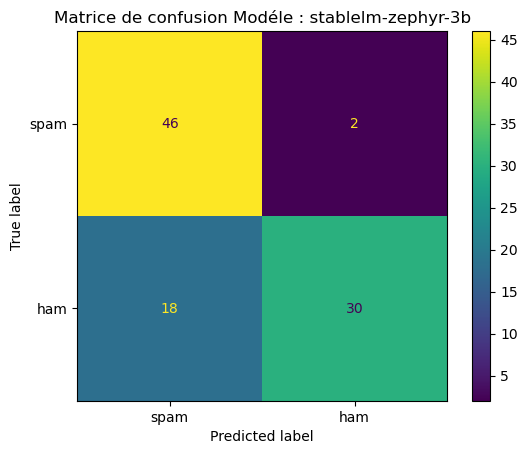

In [384]:
disp_cm_2 = ConfusionMatrixDisplay(confusion_matrix=my_cm_2, display_labels=["spam", "ham"])
disp_cm_2.plot()
disp_cm_2.ax_.set_title("Matrice de confusion Modéle : stablelm-zephyr-3b")

In [386]:
my_accuracy_2 = metrics.accuracy_score(my_data["Spam/Ham"].to_list(), df_y_pred_2[0].to_list())
my_accuracy_2

0.76

## 4. Troisième Modèle : h2oai/h2o-danube3-4b-chat

In [293]:
model_name = "h2oai/h2o-danube3-4b-chat"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto",
    trust_remote_code=True
)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [295]:
#Boucle sur le dataset au complet 
#Début du chronométrage:
my_start_time_3 = startTime()

prompt = """Classify the email as spam or non-spam. Answer just spam or non-spam. \n
Choices : 
spam
non-spam
"""

y_pred_3=[]
new_message=[]
for i in range(len(my_data)): 
    #range(len(my_data)):
    new_prompt = prompt
    new_prompt = prompt +  "\nemail : \n" + my_data["Message"][i] + "\n"
    new_message =  [
    {"role": "user", "content": new_prompt}
    ]
    #print("i = : ", i)
    new_response = compute_response(new_message)
    #print("score = ", new_response)
    y_pred_3.append(new_response)

#fin du chronométrage
my_time_spent_3 = endTime(my_start_time_3)


In [297]:
print(f" - Durée de l'opération : {my_time_spent_3:.2f} s")

 - Durée de l'opération : 6031.34 s


In [402]:
df_y_pred_3 = pd.DataFrame(y_pred_3)

In [404]:
df_y_pred_3.head()

,0
0,non-spam
1,non-spam
2,non-spam
3,non-spam
4,non-spam


In [408]:
df_y_pred_3[0].value_counts()

0
non-spam    95
spam         5
Name: count, dtype: int64

In [410]:
df_y_pred_3.loc[df_y_pred_3[0]=="non-spam", 0] = "ham"

In [418]:
df_y_pred_3[0].value_counts()

0
ham     95
spam     5
Name: count, dtype: int64

In [420]:
#matrice de confusion et performance
my_cm_3 = metrics.confusion_matrix(my_data["Spam/Ham"].to_list(), df_y_pred_3[0].to_list(), labels=["spam", "ham"])
my_classification_report_3 =  classification_report(my_data["Spam/Ham"].to_list(), df_y_pred_3[0].to_list(), labels=["spam", "ham"])
print(my_classification_report_3)

              precision    recall  f1-score   support

        spam       1.00      0.10      0.18        50
         ham       0.53      1.00      0.69        50

    accuracy                           0.55       100
   macro avg       0.76      0.55      0.44       100
weighted avg       0.76      0.55      0.44       100



Text(0.5, 1.0, 'Matrice de confusion Modéle : h2oai/h2o-danube3-4b-chat')

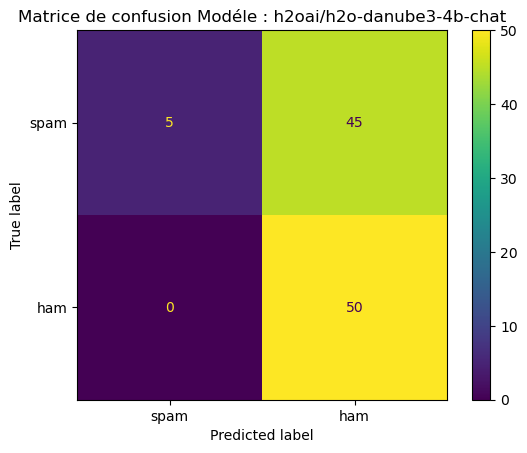

In [422]:
disp_cm_3 = ConfusionMatrixDisplay(confusion_matrix=my_cm_3, display_labels=["spam", "ham"])
disp_cm_3.plot()
disp_cm_3.ax_.set_title("Matrice de confusion Modéle : h2oai/h2o-danube3-4b-chat")

In [424]:
my_accuracy_3 = metrics.accuracy_score(my_data["Spam/Ham"].to_list(), df_y_pred_3[0].to_list())
my_accuracy_3

0.55

## 5. Analyse des résultats

Au départ de l'expérimentation,  le but était d'avoir un seul canevas de prompt pour interroger 3 modéles de petits LLM différents, en le contraignant à ne répondre que par spam ou non-spam.
Pour le modéle 2 et 3 la contrainte de répondre par seulement ces 2 mots a pu être rempli avec le même conenu de prompt. 
Par contre pour le modéle 1, plusieurs itération de contenu de prompt différents n'ont pas réussi a contraindre le modèle à ne répondre que par ces 2 possibilités de mots spam ou non-spam. 
La derniére version de prompt utilisé a été : **"Yes or No, is that email a spam ?\n"**. Un traitement des réponses a dû être fait par la suite  pour identifier les classes prédites puisque le modéle est plus bavard dans ses réponses.


### Résumé des métriques 


Modèle 1 : Durée de l'opération : 3999.08 s
Modèle 2 : Durée de l'opération : 3712.38 s
Modèle 3 : Durée de l'opération : 6031.34 s

Modèle 1: 

              precision    recall  f1-score

        spam       0.55      0.88      0.50
         ham       0.70      0.28      0 50

Modèle 2: 
Durée de l'opération : 3712.38 s
                precision    recall  f1-score   

        spam       0.72      0.92      0.50
         ham       0.94      0.60      0 

Modèle 3:
Durée de l'opération : 6031.34 s
                precision    recall  f1-score

        spam       1.00      0.10      0.50
         ham       0.53      1.00      0 5050



Le modéle 1 a une Accuracy de 58% ce qui est proche du résultat aléatoire binaire. ce qui n'est pas un bon résultat. Le _Recall_ est de 0.28 sur l'étiquette _ham_ indiquant une faible capacité à détecter des courriels clasiffés comme étant légitimes.

Le modéle 2 a obtenu de métriques plus balancées que le modèle 3. 76% des enregistrements ont été correctement classé par rapport à notre classe prédéterminée, pour un temps de traitement d'environ 62 minutes. La précision sur la détection des spam est de 0.72 et celle des emails légitimes de 0.94.

Le modéle 3 pourrait sembler être un très bon détecteur de spam car sa précision est de 1, pour cette catégorie. Il a mis environ 100 minutes pour traiter 100 courriels.
La matrice de confusion de ce modèle montre que 95% de l'échantillon des email ont été classés comme non-spam. alors que le jeu de données est balancé (50/50) expliquant ainsi le faible Recall de 0.10.

## Conclusion

En résumé le modéle 2 "stabilityai/stablelm-zephyr-3b" a eu la meilleure performance. De plus, nous avons été capable de le contraindre à ne donner qu'un seul type de réponse soit spam ou non-spam dans un temps de traitement d'environ 1 heure pour 100 courriels en entréeé

